based on https://stackoverflow.com/questions/59381695/lstm-in-pytorch-how-to-add-change-sequence-length-dimension

In [1]:
from fastai.tabular import *
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# Data preparation

## Get the data

In [2]:
class CryptoDataset:
    """Face Landmarks dataset."""
    CLOSING_PRICE = 'close'
    PREV_CLOSING_PRICE = 'prev_close'
    DATE_COLUMN_NAME = 'date'
    ELAPSED = 'Elapsed'
    DROP_COLUMNS =['Second', 'Month', 'Year', \
                   'Is_quarter_end', 'Is_quarter_start', \
                   'Is_year_end', 'Is_year_start',
                   'Is_month_end', 'Is_month_start',
                   'Week', 'Dayofyear', ELAPSED]
    Target_closing_price_column_name = 'target_' + CLOSING_PRICE + '_future'
#     Target_is_turn_point = 'target_is_turn_point'
    This_is_top_turn_point = 'this_is_top_turn_point'
    This_is_bottom_turn_point = 'this_is_bottom_turn_point'

    def __init__(self, csv_file="BTC-ETH-filtered_with_indicators.csv", predict_delta=1, sequence_size=10, batch_size=8):
        """
        Args:
            csv_file (string): Path to the csv file with the crypto stats table.
        """
        from datetime import datetime
        self.sequence_size = sequence_size
        self.df = pd.read_csv("BTC-ETH-filtered_with_indicators.csv",
                              #read dates as dates
                              parse_dates=[self.DATE_COLUMN_NAME],
                              date_parser=lambda x: datetime.fromtimestamp(int(x)))
        add_datepart(self.df, self.DATE_COLUMN_NAME, time=True);
        self.df = self.df.astype(float).drop(columns=self.DROP_COLUMNS)
        
        # building the target
        self.df[self.Target_closing_price_column_name] = self.df.astype(float)[self.CLOSING_PRICE].shift(-predict_delta)
#         print(self.df.iloc[-1,:])
        self.df = self.df[:-1]
#         print(self.df.iloc[-1,:])
        
        ### customized for delta == 1
        self.df[self.PREV_CLOSING_PRICE] = self.df[self.CLOSING_PRICE].shift(1)
        self.df[self.This_is_top_turn_point] = self.df.apply(lambda x: \
                                                         (x[self.CLOSING_PRICE] > x[self.Target_closing_price_column_name] and \
                                                          x[self.CLOSING_PRICE] > x[self.PREV_CLOSING_PRICE]), 
                                                         axis=1)
        self.df[self.This_is_bottom_turn_point] = self.df.apply(lambda x: \
                                                        (x[self.CLOSING_PRICE] < x[self.Target_closing_price_column_name] and \
                                                         x[self.CLOSING_PRICE] < x[self.PREV_CLOSING_PRICE]), 
                                                        axis=1)
#         print(self.df.columns)
        
        trvate_split = tuple(int(x * len(self.df)) for x in (0.75, 0.9, 1.0))
        tmp_train_limit = trvate_split[0]- trvate_split[0]%sequence_size
        self.train_df = self.df[:tmp_train_limit]
        tmp_valid_limit = trvate_split[1] - trvate_split[0]%sequence_size -(trvate_split[1]-trvate_split[0])%sequence_size
        self.valid_df = self.df[tmp_train_limit:tmp_valid_limit]
        self.test_df = self.df[tmp_valid_limit:(len(self.df)- len(self.df)%sequence_size)]
        del tmp_train_limit, tmp_valid_limit
        
        def __transform_df(df_to_transform, transformer, columns):
            return pd.DataFrame(transformer.transform(df_to_transform), columns=columns)
        
        preprocessing_pipeline = Pipeline([("poli-feature", PolynomialFeatures(degree=2)),
                                           ("normalizer", StandardScaler())
                                          ]).fit(self.train_df.input_data(), self.train_df.target())
#         preprocessing_pipeline = StandardScaler().fit(self.train_df.input_data())
#         columns = self.train_df.input_data().columns
        columns = preprocessing_pipeline["poli-feature"].get_feature_names(self.train_df.input_data().columns)
        self.train_data = __transform_df(self.train_df.input_data(), preprocessing_pipeline, columns=columns)
        self.valid_data =__transform_df(self.valid_df.input_data(), preprocessing_pipeline, columns=columns)
        self.test_data = __transform_df(self.test_df.input_data(), preprocessing_pipeline, columns=columns)

        self.train_data.drop(columns=['1'], inplace=True)
        self.valid_data.drop(columns=['1'], inplace=True)
        self.test_data.drop(columns=['1'], inplace=True)
        
        def create_inout_sequences(input_data: pd.DataFrame, labels: pd.DataFrame, seq_len: int):
            out_labels = torch.tensor(labels.iloc[seq_len-1:].values.astype(np.float32))
            print(input_data.shape)
            out_sequences = np.stack([input_data.iloc[i:i+seq_len] for i in range(len(input_data)-seq_len+1)])
            out_data = torch.tensor(out_sequences.reshape(-1, seq_len, input_data.shape[-1]).astype(np.float32))
            print(input_data.shape, out_data.shape, out_labels.shape)
            return out_data, out_labels
        
#         train_x_y
        self.train_loader = DataLoader(dataset=TensorDataset(*create_inout_sequences(input_data=self.train_data,
                                                                                    labels=self.train_df.target(),
                                                                                    seq_len=sequence_size)),
                                       batch_size=batch_size, shuffle = True)
        self.val_loader = DataLoader(dataset=TensorDataset(*create_inout_sequences(input_data=self.valid_data,
                                                                                    labels=self.valid_df.target(),
                                                                                    seq_len=sequence_size)),
                                       batch_size=batch_size)
        self.test_loader = DataLoader(dataset=TensorDataset(*create_inout_sequences(input_data=self.test_data,
                                                                                    labels=self.test_df.target(),
                                                                                    seq_len=sequence_size)),
                                       batch_size=batch_size)

In [4]:
# def input_data(self: pd.DataFrame):
#     return self.drop(columns=[CryptoDataset.Target_closing_price_column_name])
# def target(self: pd.DataFrame):
#     return self[[CryptoDataset.Target_closing_price_column_name]]

# pd.DataFrame.input_data = input_data
# pd.DataFrame.target = target

### dataset build

In [ ]:
# BATCH_SIZE = 1
# SEQUENCE_SIZE = 4
# dataset=CryptoDataset(predict_delta=1,
#                       batch_size=BATCH_SIZE,
#                       sequence_size=SEQUENCE_SIZE)

# Study

In [ ]:
# from IPython.display import display
# pd.set_option('display.max_columns', 500)
# np.set_printoptions(threshold=sys.maxsize)
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor()
# rf.fit(dataset.train_df.input_data(), dataset.train_df.target())
# print(rf.feature_importances_)
# all_features = dataset.train_df.input_data().columns
# print("all columns\n", *[str(a) +'\n ' for a in zip(all_features, rf.feature_importances_)])
# plot_params = 'parameters'
# plot_importances = 'importances'
# df = pd.DataFrame({plot_params:all_features[rf.feature_importances_ > 0.].tolist(),
#                    plot_importances:rf.feature_importances_[rf.feature_importances_ > 0.]})
# ax = df.plot.bar(x=plot_params, y=plot_importances, rot=0)

### dataset build

In [3]:
def input_data(self: pd.DataFrame):
    return self[['open', 'high', 'low', 'close', 'others_cr']]

pd.DataFrame.input_data = input_data


def target(self: pd.DataFrame):
    return self[[CryptoDataset.Target_closing_price_column_name,
                 CryptoDataset.This_is_bottom_turn_point, 
                 CryptoDataset.This_is_top_turn_point]]

pd.DataFrame.target = target

In [10]:
BATCH_SIZE = 16
SEQUENCE_SIZE = 24
dataset=CryptoDataset(predict_delta=1,
                      batch_size=BATCH_SIZE,
                      sequence_size=SEQUENCE_SIZE)

(1032, 20)
(1032, 20) torch.Size([1009, 24, 20]) torch.Size([1009, 3])
(192, 20)
(192, 20) torch.Size([169, 24, 20]) torch.Size([169, 3])
(168, 20)
(168, 20) torch.Size([145, 24, 20]) torch.Size([145, 3])


# Train

In [5]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

## Model

In [6]:
class SentimentNet(nn.Module):
    def __init__(self, features, output_size=1,
#                  embedding_dim=10,
#                  hidden_dim=50,
                 sequence_size=10,
                 n_layers=1,
                 drop_prob=0.5, device=torch.device("cpu")):
        super(SentimentNet, self).__init__()
        
        embedding_dim=features*2
        hidden_dim=features
        
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device
        
        self.liniar = nn.Linear(features, embedding_dim)
        self.bn1 = nn.BatchNorm1d(num_features=sequence_size, affine=False) # embedding_dim)
        
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=n_layers, dropout=drop_prob, batch_first=True)
#         self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim//2),
                                nn.BatchNorm1d(num_features=hidden_dim//2, affine=False),# if reenabling, search for "No need to skip this since have dropped the bn"
                                nn.Dropout(drop_prob),
                                nn.Tanh(),
                                nn.Linear(hidden_dim//2, output_size))
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        # Initialize cell state
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        
        out = self.liniar(x)
#         print(out.shape)
        out = self.bn1(out)
        out = F.relu(out)
#         print(out.shape)
        out, (hn, cn) = self.lstm(out, (h0, c0))
#         print(out.shape)
        # Index hidden state of last time step
        out = self.fc(out[:, -1, :])
        out[:,-1] = F.sigmoid(out[:,-1])
        out[:,-2] = F.sigmoid(out[:,-2])
        
        return out

In [ ]:
# class CustomLoss(nn.L1Loss):
#     def __init__(self, size_average=None, reduce=None, reduction='mean'):
#         super(CustomLoss, self).__init__(size_average, reduce, reduction)

#     def forward(self, input, target):
#         return 10.0 * F.l1_loss(input, target, reduction=self.reduction)
        

In [52]:
features_count = dataset.train_data.shape[1]
output_count = len(dataset.train_df.target().columns)
# output_size = 1
# embedding_dim = 400
# hidden_dim = 512
# n_layers = 2

model = SentimentNet(features_count, output_size=output_count,
                     device=DEVICE, n_layers=2, sequence_size=SEQUENCE_SIZE, drop_prob=0.)
model.to(DEVICE)

lr=0.001
# criterion = CustomLoss()
criterion = nn.L1Loss()
binary_criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 300
counter = 0
print_every = 5
clip = 5
valid_loss_min = np.Inf
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                   steps_per_epoch=len(dataset.train_loader),
                                                   epochs=epochs)

In [53]:
%matplotlib notebook
import matplotlib.pyplot as plt
train_losses, valid_losses = [], []

<IPython.core.display.Javascript object>


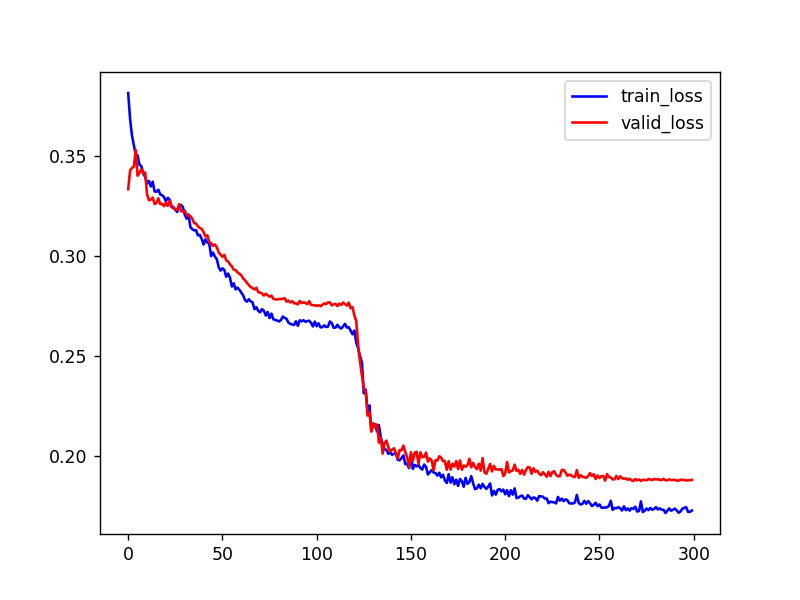

Epoch: 0... Loss: 0.381404... Val Loss: 0.333340
Validation loss decreased (inf --> 0.333340).  Saving model ...
Epoch: 1... Loss: 0.368476... Val Loss: 0.342605
Epoch: 2... Loss: 0.360286... Val Loss: 0.343968
Epoch: 3... Loss: 0.355308... Val Loss: 0.344653
Epoch: 4... Loss: 0.350638... Val Loss: 0.353021
Epoch: 5... Loss: 0.350203... Val Loss: 0.340054
Epoch: 6... Loss: 0.345521... Val Loss: 0.341579
Epoch: 7... Loss: 0.344862... Val Loss: 0.343277
Epoch: 8... Loss: 0.341196... Val Loss: 0.341280
Epoch: 9... Loss: 0.339514... Val Loss: 0.341668
Epoch: 10... Loss: 0.336132... Val Loss: 0.330783
Validation loss decreased (0.333340 --> 0.330783).  Saving model ...
Epoch: 11... Loss: 0.337508... Val Loss: 0.327793
Validation loss decreased (0.330783 --> 0.327793).  Saving model ...
Epoch: 12... Loss: 0.334685... Val Loss: 0.328149
Epoch: 13... Loss: 0.337081... Val Loss: 0.329134
Epoch: 14... Loss: 0.332184... Val Loss: 0.325938
Validation loss decreased (0.327793 --> 0.325938).  Saving

Epoch: 88... Loss: 0.265475... Val Loss: 0.276324
Validation loss decreased (0.276745 --> 0.276324).  Saving model ...
Epoch: 89... Loss: 0.267331... Val Loss: 0.276281
Validation loss decreased (0.276324 --> 0.276281).  Saving model ...
Epoch: 90... Loss: 0.265083... Val Loss: 0.275744
Validation loss decreased (0.276281 --> 0.275744).  Saving model ...
Epoch: 91... Loss: 0.267848... Val Loss: 0.277459
Epoch: 92... Loss: 0.267340... Val Loss: 0.276438
Epoch: 93... Loss: 0.267852... Val Loss: 0.276777
Epoch: 94... Loss: 0.267104... Val Loss: 0.276593
Epoch: 95... Loss: 0.267453... Val Loss: 0.275862
Epoch: 96... Loss: 0.267600... Val Loss: 0.277356
Epoch: 97... Loss: 0.266527... Val Loss: 0.275558
Validation loss decreased (0.275744 --> 0.275558).  Saving model ...
Epoch: 98... Loss: 0.264750... Val Loss: 0.275381
Validation loss decreased (0.275558 --> 0.275381).  Saving model ...
Epoch: 99... Loss: 0.267190... Val Loss: 0.275271
Validation loss decreased (0.275381 --> 0.275271).  Sav

Epoch: 212... Loss: 0.180417... Val Loss: 0.194505
Epoch: 213... Loss: 0.179465... Val Loss: 0.194248
Epoch: 214... Loss: 0.178356... Val Loss: 0.191127
Epoch: 215... Loss: 0.179316... Val Loss: 0.193844
Epoch: 216... Loss: 0.179014... Val Loss: 0.192131
Epoch: 217... Loss: 0.177697... Val Loss: 0.192729
Epoch: 218... Loss: 0.180006... Val Loss: 0.191181
Epoch: 219... Loss: 0.179745... Val Loss: 0.190405
Epoch: 220... Loss: 0.179736... Val Loss: 0.191948
Epoch: 221... Loss: 0.178710... Val Loss: 0.190860
Epoch: 222... Loss: 0.178852... Val Loss: 0.189635
Validation loss decreased (0.189989 --> 0.189635).  Saving model ...
Epoch: 223... Loss: 0.176458... Val Loss: 0.192141
Epoch: 224... Loss: 0.177255... Val Loss: 0.189945
Epoch: 225... Loss: 0.176927... Val Loss: 0.191971
Epoch: 226... Loss: 0.176925... Val Loss: 0.192414
Epoch: 227... Loss: 0.176317... Val Loss: 0.190545
Epoch: 228... Loss: 0.179608... Val Loss: 0.189840
Epoch: 229... Loss: 0.177719... Val Loss: 0.189957
Epoch: 230...

In [54]:
model.train()
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epochs')
ax.set_ylabel('losses')

def train():
    model.train()

    for train, train_target in dataset.train_loader:
        if train.shape[0] < 2:# No need to skip this since have dropped the bn
            continue
            
        # Load data as a torch tensor with gradient accumulation abilities
        train = train.requires_grad_().to(DEVICE)
        train_target = train_target.to(DEVICE)
#         print(train.shape)
#         print(train_target.shape)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        # Forward pass to get output/logits
        outputs = model(train)
#         print(outputs.shape, train_target.shape)
        # Calculate Loss: softmax --> cross entropy loss
        loss = 0.9 * criterion(outputs[:,0], train_target[:,0]) + \
               0.1 * (binary_criterion(outputs[:,1], train_target[:, 1]) + \
                      binary_criterion(outputs[:,2], train_target[:, 2]))

        # Getting gradients w.r.t. parameters
        loss.backward()
        # Updating parameters
#         nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        lr_scheduler.step()

def eval_and_save(on_epoch=0):
    model.eval()
    global valid_loss_min
    
    #evaluate first the full train set
    epoch_train_losses = []
    for train, train_target in dataset.train_loader:
        # Forward pass to get output/logits
        train = train.to(DEVICE)
        train_target = train_target.to(DEVICE)
        outputs = model(train)
        train_loss = criterion(outputs, train_target)
        epoch_train_losses.append(train_loss.item())
    avg_epoch_train_loss = np.mean(epoch_train_losses)
    train_losses.append(avg_epoch_train_loss)
   
        
    #eval the valid set
    epoch_val_losses = []
    for val_in, val_out in dataset.val_loader:
        # Forward pass to get output/logits
        val_in = val_in.to(DEVICE)
        val_out = val_out.to(DEVICE)
        outputs = model(val_in)
        val_loss = criterion(outputs, val_out)
        epoch_val_losses.append(val_loss.item())
    avg_epoch_val_loss = np.mean(epoch_val_losses)
    valid_losses.append(avg_epoch_val_loss)
    
    
    print("Epoch: {}...".format(epoch),
          "Loss: {:.6f}...".format(avg_epoch_train_loss),
          "Val Loss: {:.6f}".format(avg_epoch_val_loss))
    if avg_epoch_val_loss < valid_loss_min:
        torch.save(model.state_dict(), './state_dict9.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,avg_epoch_val_loss))
        valid_loss_min = avg_epoch_val_loss
            

    plt.cla()
    ax.plot(train_losses, 'b', label='train_loss')
    ax.plot(valid_losses, 'r', label='valid_loss')
    ax.legend()
    fig.canvas.draw()
            
        
for epoch in range(epochs):
    train()
    eval_and_save(epoch)
        

# Test

## Visualize

In [14]:
import matplotlib.pyplot as plt

class Visualizer:
    colors=['blue','black', 'red']
    
    def __init__(self):
        self.date_pred_targ_dict: dict = dict()
        
    def add(self, timestamp, pred, targ, color='red'):
        self.date_pred_targ_dict[color] = pd.concat([self.date_pred_targ_dict.get(color, pd.DataFrame()),
                                                     pd.concat([pd.DataFrame(timestamp),
                                                       pd.DataFrame(pred),
                                                       pd.DataFrame(targ)], axis=1)])
    
    def plot(self):
        for color in self.colors:
            color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
            plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
            plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
            plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
            plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
        plt.show()

## Eval

In [55]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict9.pt'))
visualizer = Visualizer()

mse_losses = []
mae_losses = []
kldiv_losses = []
totalIndexes = 0
custom_batch = BATCH_SIZE
# index_of_elapsed = dataset.train_data.columns.tolist().index(dataset.ELAPSED)

model.eval()

# #TRAIN
# for inputs, labels in tqdm(dataset.train_loader):
#     if inputs.shape[0] != custom_batch:
#         continue
#       totalIndexes += 1
#     inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
#     output, h = model(inputs, h)
#     visualizer.add(np.arange(len(inputs)), output, labels[:,-1], color='black')
    
#VALIDATE       
for val_in, val_out in dataset.val_loader:
    # Forward pass to get output/logits
    val_in = val_in.to(DEVICE)
    val_out = val_out.to(DEVICE)
    outputs = model(val_in)
#     val_loss = criterion(outputs, val_out)
#     val_losses.append(val_loss.item())

    visualizer.add(np.arange(len(val_out))+totalIndexes, np.array(outputs[:,0]), np.array(val_out[:,0]), color='blue')
    totalIndexes += len(val_out)
    
#TEST
for test_in, test_out in dataset.test_loader:
    # Forward pass to get output/logits
    test_in = test_in.to(DEVICE)
    test_out = test_out.to(DEVICE)
    outputs = model(test_in)
#     val_loss = criterion(outputs, val_out)
#     val_losses.append(val_loss.item())

    visualizer.add(np.arange(len(test_out))+totalIndexes, np.array(outputs[:,0]), np.array(test_out[:,0]))
    totalIndexes += len(test_out)
    
    mse_losses.append(nn.MSELoss()(outputs, test_out).item())
    mae_losses.append(nn.L1Loss()(outputs, test_out).item())
    kldiv_losses.append(nn.KLDivLoss()(outputs, test_out).item())
    

print("MSE loss: {:.8f}".format(np.mean(mse_losses)))
print("MAE loss: {:.8f}".format(np.mean(mae_losses)))
print("KLDiv loss: {:.8f}".format(np.mean(kldiv_losses)))

MSE loss: 0.09644919
MAE loss: 0.18591251
KLDiv loss: -0.10953111


### BS10 maxLR==lr 2lstms
lr=0.0003

In [ ]:
visualizer.date_pred_targ_dict['blue']

<IPython.core.display.Javascript object>


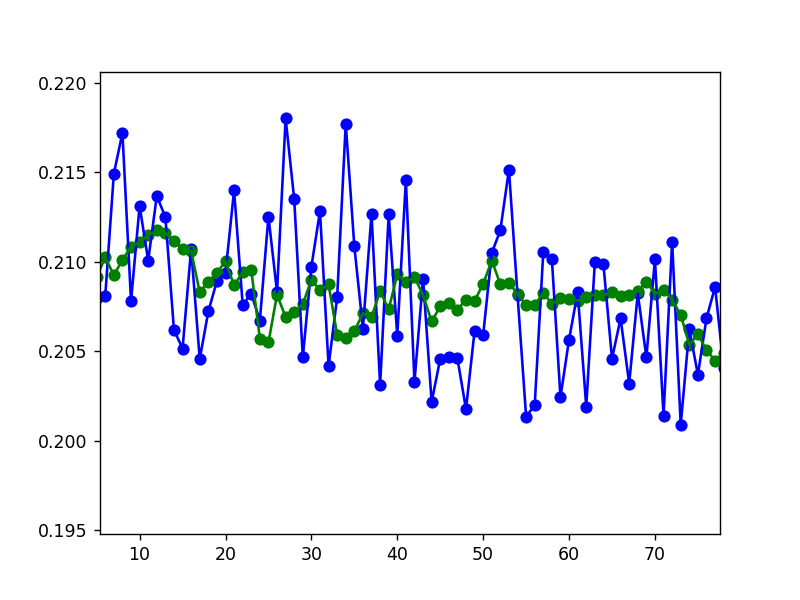

In [56]:
plt.figure()
for color in ['blue']:
    color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
plt.show()

<IPython.core.display.Javascript object>


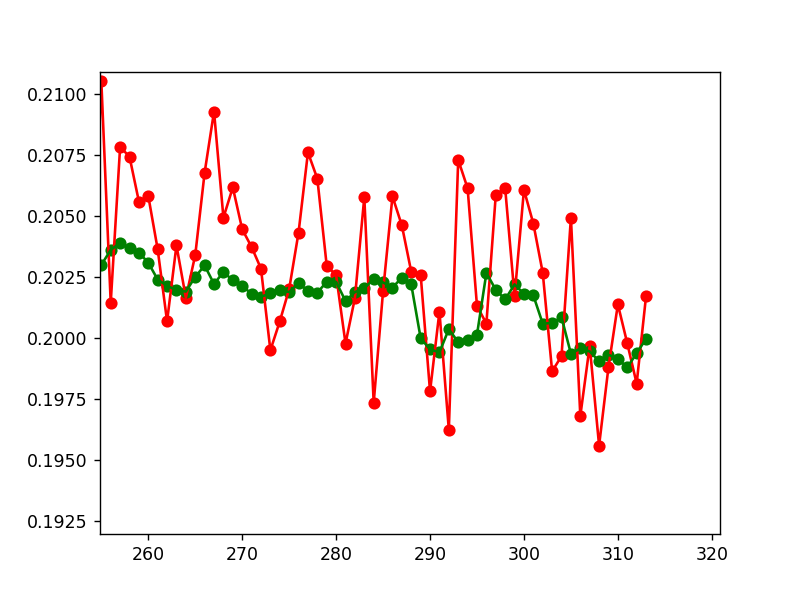

In [57]:
plt.figure()

for color in ['red']:
    color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
plt.show()

# should try estimate (min / max) on next 4 timestamps